In [1]:
import json
import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob
import pandas as pd
import numpy as np
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import os
import tweepy as tw
import pandas as pd

from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


Sentiment= pd.read_csv("SAD.csv", error_bad_lines = False)




b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [3]:
Sentiment.head()
x = Sentiment.SentimentText
y = Sentiment.Sentiment

In [5]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)



In [6]:
tvec = TfidfVectorizer(max_features = 100000, ngram_range = (1,3))
tvec.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=100000, min_df=1, ngram_range=(1, 3), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [7]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

lr = LogisticRegression()
lr.fit(x_train_tfidf,y_train)

lr.score(x_test_tfidf,y_test)
yhat_lr = lr.predict_proba(x_test_tfidf)

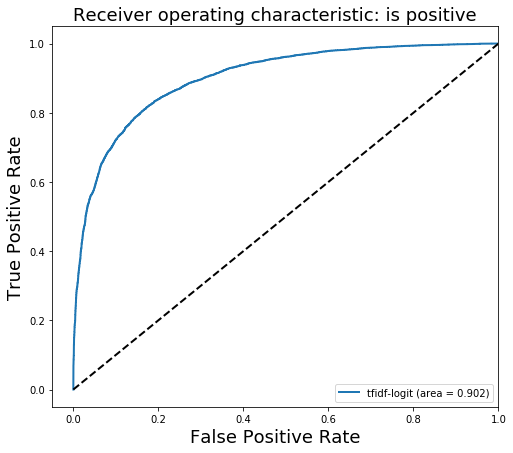

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)


plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [10]:
Sentiment.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [11]:
len(Sentiment)

1578612

In [15]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

Pipeline1 = Pipeline([('vectorizer', tvec, 'feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
          ('classification', LinearSVC(penalty="l2"))])

sentiment_fit = Pipeline1.fit(x_train_tfidf, y_train)
y_pred = sentiment_fit.predict(x_test_tfidf)

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.8144042566668778

In [22]:
confusion_matrix(y_test, y_pred)

array([[6360, 1569],
       [1361, 6497]])

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [24]:
precision_score(y_test, y_pred, average=None)

array([0.8237275 , 0.80547979])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr_SVM, tpr_SVM, threshold = roc_curve(y_test, yhat_SVM_L1[:,1])
roc_auc_SVM = auc(fpr, tpr)
plt.figure(figsize=(8,7))
plt.plot(fpr_SVM, tpr_SVM, label='tfidf-SVC-L1(area = %0.3f)' % roc_auc_SVM, linewidth=2)


plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('             negative     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [35]:
Sentiment.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [39]:
Sentiment[Sentiment.Sentiment == 0]

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
5,6,0,Sentiment140,or i just worry too much?
...,...,...,...,...
1578602,1578618,0,Sentiment140,Zzzz lying in bed watching the countryside thr...
1578606,1578622,0,Sentiment140,Zzzzz want to sleep but at sister's in-laws's ...
1578609,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.
1578610,1578626,0,Sentiment140,"ZzZzzzZZZZzzz meh, what am I doing up again?"


In [40]:
Sentiment[Sentiment.Sentiment == 1]

,ItemID,Sentiment,SentimentSource,SentimentText
2,3,1,Sentiment140,omg its already 7:30 :O
6,7,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,9,1,Sentiment140,handed in my uniform today . i miss you ...
9,10,1,Sentiment140,hmmmm.... i wonder how she my number @-)
11,12,1,Sentiment140,thanks to all the haters up in my face a...
...,...,...,...,...
1578603,1578619,1,Sentiment140,Zzzz... Fuck Ã¼ : Zzzz... Fuck Ã¼ http://bit....
1578604,1578620,1,Sentiment140,Zzzz...no work tomorrow..yayyy!!
1578605,1578621,1,Sentiment140,ZZZZZ time.. Tomorrow will be a busy day for s...
1578607,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!


Text(0.5, 1.02, 'Sentiment140')

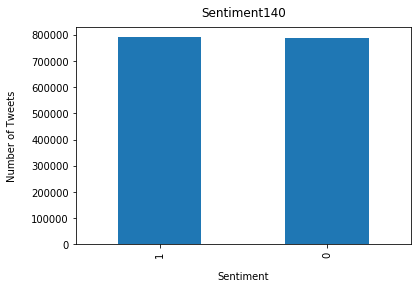

In [53]:
Sentiment['Sentiment'].value_counts().plot('bar')
plt.xlabel("Sentiment", labelpad=14)
plt.ylabel("Number of Tweets", labelpad=14)
plt.title("Sentiment140", y=1.02)


In [54]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)



In [55]:
len(x_train)

1547039

In [56]:
len(x_test)

15787

In [57]:
len(x_train)+len(x_test)

1562826

In [58]:
len(x_validation_and_test)

31573

In [ ]:
len